## Predicting Cost of Caterpillar<sup>TM</sup> Tube Assemblies.
 

In [33]:
# Imports

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


In [34]:
%matplotlib inline
pd.set_option('display.max_columns', 100)


Begin examining, cleaning and organizing data.


In [35]:
# Get data into dataframes.
trainval = pd.read_csv('data/competition_data/train_set.csv')
test = pd.read_csv('data/competition_data/test_set.csv')


In [36]:
# See what we're working with.
trainval.head()


,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561


In [37]:
test.head()


,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [38]:
# Ensure dates are datetimes.
trainval['quote_date'] = pd.to_datetime(trainval['quote_date'], infer_datetime_format=True)
test['quote_date'] = pd.to_datetime(test['quote_date'], infer_datetime_format=True)

# Is our data chronological?
trainval['quote_date'].describe()


count                   30213
unique                   1781
top       2013-10-01 00:00:00
freq                     2877
first     1982-09-22 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

In [39]:
test['quote_date'].describe()


count                   30235
unique                   1778
top       2013-09-01 00:00:00
freq                     2992
first     1985-11-16 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

In [40]:
# Dates are concurrent. The sets must be separated in another way.
set(trainval['tube_assembly_id'].unique()) & set(test['tube_assembly_id'].unique())


set()

In [41]:
# Assembly id is not shared, split training data into train and validate by assembly id.
trainval_assemblies = trainval['tube_assembly_id'].unique()
test_assemblies = test['tube_assembly_id'].unique()

train_tubes, val_tubes = train_test_split(trainval_assemblies, random_state=42)

train = trainval[trainval['tube_assembly_id'].isin(train_tubes)]
val = trainval[trainval['tube_assembly_id'].isin(val_tubes)]
train.shape, val.shape


((22628, 8), (7585, 8))

Get a dummy baseline prediction for later comparison.


In [42]:
# Our error metric will be Root Mean Squared Log Error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


In [43]:
# Use the cost mean to make our cost prediction.
target = 'cost'
y_train = train[target]
y_val = val[target]

y_pred = np.full_like(y_val, fill_value=y_train.mean())
print(f'Validation RMSLE, Mean Baseline: {rmsle(y_val, y_pred)}')


Validation RMSLE, Mean Baseline: 0.9418101276064408


Off by 94%. Improvements can be made. Start with a very simple model.


In [44]:
features = ['quantity']
X_train = train[features]
X_val = val[features]

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=3,
                              random_state=42)
model.fit(X_train, y_train)
r2 = model.score(X_val, y_val)
print(f'Validation R^2 score: {r2}')

y_pred = model.predict(X_val)
print(f'Validation RMSLE, with one feature: {features[0]}\n: {rmsle(y_val, y_pred)}')


Validation R^2 score: 0.08879518736792147
Validation RMSLE, with one feature: quantity
: 0.6908805822519186


Quite a bit better than before, but much more room to improve. 


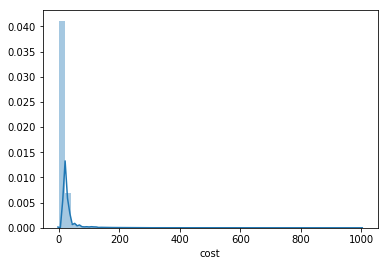

In [45]:
# Check out the distribution of the target, cost.
sns.distplot(y_train);


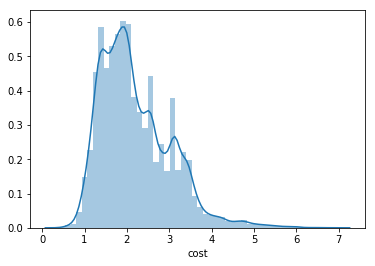

In [46]:
# We can get these into a smaller space by taking the log of each target value.
y_train_log = np.log1p(y_train)
sns.distplot(y_train_log);


In [47]:
# Now predict with a model fit on scaled targets.
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(f'RMSLE with scaled targets: {rmsle(y_val, y_pred)}')


RMSLE with scaled targets: 0.622925465880199


A 7% improvement over the non-scaled targets.


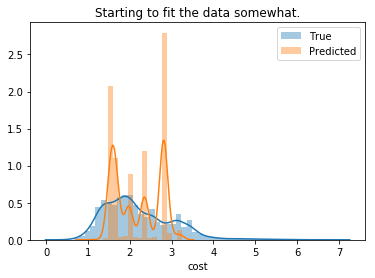

In [48]:
y_val_log = np.log1p(y_val)
sns.distplot(y_val_log, label='True')
sns.distplot(y_pred_log, label='Predicted')
plt.title('Starting to fit the data somewhat.')
plt.legend();


Engineer some features from the data we have so far.


In [49]:
def clean(data):
    df = data.copy()
    
    df['quote_date'] = pd.to_datetime(df['quote_date'], infer_datetime_format=True)
    df['quote_year'] = df['quote_date'].dt.year
    df['quote_month'] = df['quote_date'].dt.month
    df = df.drop(columns='quote_date')
    
    # df = df.drop(columns='tube_assembly_id')
    return df


In [50]:
train_clean = clean(train)
val_clean = clean(val)


In [51]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [52]:
# Use new features and assess any improvement.
features = train_clean.columns.drop('cost')
X_train = train_clean[features]
X_val = val_clean[features]


In [53]:
pipeline = make_pipeline(OrdinalEncoder(),
                         RandomForestRegressor(n_estimators=100,
                                               n_jobs=3,
                                               random_state=42))
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(f'RMSE for model with new features: {rmse(y_val_log, y_pred_log)}')
print(f'RMSLE: {rmsle(y_val, y_pred)}')


RMSE for model with new features: 0.43919385455635707
RMSLE: 0.43919385455635707


Nice!


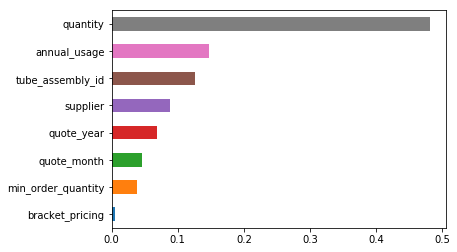

In [54]:
# What features are most important for making predictions?
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh()


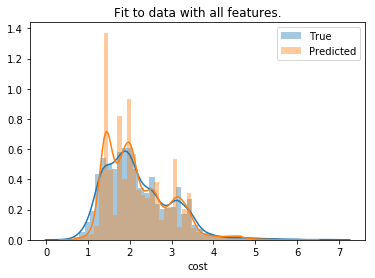

In [55]:
# Have we improved fit any more?
sns.distplot(y_val_log, label='True')
sns.distplot(y_pred_log, label='Predicted')
plt.title('Fit to data with all features.')
plt.legend();


Add more features by combining relational data.


In [56]:
data = {}
for path in glob('data/competition_data/*.csv'):
    df = pd.read_csv(path)
    file = re.search(r'(?<=\\)(.+)(?=[.])', path)
    data[file.group(1)] = df


In [57]:
for name, frame in data.items():
    print(name)
    print(frame.head())
    print()


bill_of_materials
  tube_assembly_id component_id_1  quantity_1 component_id_2  quantity_2  \
0         TA-00001         C-1622         2.0         C-1629         2.0   
1         TA-00002         C-1312         2.0            NaN         NaN   
2         TA-00003         C-1312         2.0            NaN         NaN   
3         TA-00004         C-1312         2.0            NaN         NaN   
4         TA-00005         C-1624         1.0         C-1631         1.0   

  component_id_3  quantity_3 component_id_4  quantity_4 component_id_5  \
0            NaN         NaN            NaN         NaN            NaN   
1            NaN         NaN            NaN         NaN            NaN   
2            NaN         NaN            NaN         NaN            NaN   
3            NaN         NaN            NaN         NaN            NaN   
4         C-1641         1.0            NaN         NaN            NaN   

   quantity_5 component_id_6  quantity_6 component_id_7  quantity_7  \
0        

In [58]:
data['tube'].head()
# We can left join this with our current data for more features.


,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [59]:
train = train.merge(data['tube'], how='left')
val = val.merge(data['tube'], how='left')
train.head()


,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00004,S-0066,2013-07-07,0,0,Yes,5,6.668596,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,S-0066,2013-07-07,0,0,Yes,10,4.754539,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00004,S-0066,2013-07-07,0,0,Yes,25,3.608331,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0


In [60]:
train = clean(train)
val = clean(val)

features = train.columns.drop('cost')

X_train = train[features]
X_val = val[features]
pipeline = make_pipeline(OrdinalEncoder(),
                         RandomForestRegressor(n_estimators=10,
                                               n_jobs=3,
                                               random_state=42))
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
y_pred = np.expm1(y_pred_log)


In [61]:
print(f'RMSE with additional features: {rmse(y_val_log, y_pred_log)}')


RMSE with additional features: 0.35527038549127854


In [62]:
train = train.merge(data['bill_of_materials'], on='tube_assembly_id', how='left')
val = val.merge(data['bill_of_materials'], on='tube_assembly_id', how='left')


In [63]:
# features = train.drop(columns=['tube_assembly_id', 'cost']).columns
X_train = train[features]
X_val = val[features]
pipeline = make_pipeline(OrdinalEncoder(),
                         RandomForestRegressor(n_estimators=100,
                                               n_jobs=3,
                                               random_state=42))
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
print(f'RMSE with even more features: {rmse(y_val_log, y_pred_log)}')


RMSE with even more features: 0.3274274247375385


In [64]:
train.head()


,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,quote_year,quote_month,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00004,S-0066,0,0,Yes,1,21.972702,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,2013,7,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00004,S-0066,0,0,Yes,2,12.407983,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,2013,7,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00004,S-0066,0,0,Yes,5,6.668596,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,2013,7,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,S-0066,0,0,Yes,10,4.754539,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,2013,7,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00004,S-0066,0,0,Yes,25,3.608331,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0,2013,7,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
comp_hfl = data['comp_hfl']
comp_hfl['hfl_material'] = comp_hfl['component_id']